# Phase 3 — Customer Segmentation (AI-Driven Churn Prediction Project)

**Goal:**  
Create actionable customer segments using the scored output from Phase 2 (`churn_proba`) plus key behavioral/value features.


In [1]:
# 0) Setup + Load Phase 2 Scored Dataset                  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
# Load Phase 2 scored dataset
df = pd.read_csv("../data/processed/scored_customers.csv")

# Quick sanity check
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_proba,pred_churn_04
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.622651,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0.044294,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0.286630,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0.028434,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0.690068,1


In [5]:
# Make sure Phase 3 input is correct
print(df.shape)
print("churn_proba exists:", "churn_proba" in df.columns)


(7032, 23)
churn_proba exists: True


In [6]:
df.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'churn_proba', 'pred_churn_04'],
      dtype='object')

In [7]:
# 1) Base segmentation features (always useful)
seg_features = ["tenure", "MonthlyCharges", "TotalCharges", "churn_proba"]

# 2) Add optional engineered numeric features IF they exist in your df
optional_features = [
    "SeniorCitizen",          # already numeric (0/1) in your data
    "num_services",           # if you created it in Phase 2
    "is_month_to_month",      # if you created it in Phase 2
    "paperless_flag"          # if you created it in Phase 2
]

seg_features += [c for c in optional_features if c in df.columns]

print("Segmentation features used:", seg_features)


Segmentation features used: ['tenure', 'MonthlyCharges', 'TotalCharges', 'churn_proba', 'SeniorCitizen']


In [8]:
X = df[seg_features].copy()

# TotalCharges sometimes has missing/blank issues; drop any missing here for clustering
X = X.dropna()

# Confirm all are numeric
non_numeric = X.select_dtypes(exclude=["number"]).columns.tolist()
print("Non-numeric columns in X:", non_numeric)

assert len(non_numeric) == 0, f"Convert/remove non-numeric columns: {non_numeric}"

print("X shape:", X.shape)
X.head()


Non-numeric columns in X: []
X shape: (7032, 5)


,tenure,MonthlyCharges,TotalCharges,churn_proba,SeniorCitizen
0,1,29.85,29.85,0.622651,0
1,34,56.95,1889.50,0.044294,0
2,2,53.85,108.15,0.286630,0
3,45,42.30,1840.75,0.028434,0
4,2,70.70,151.65,0.690068,0


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(7032, 5)

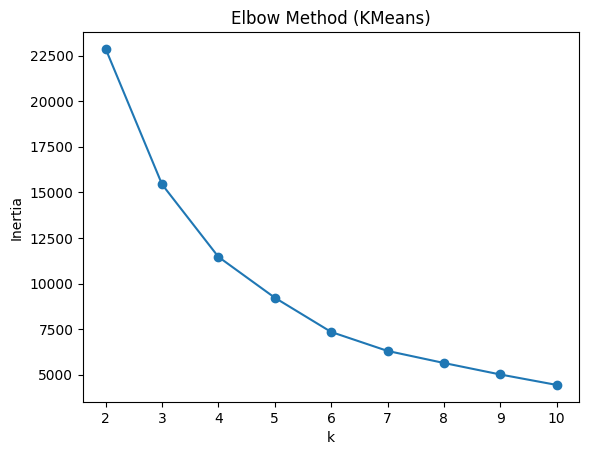

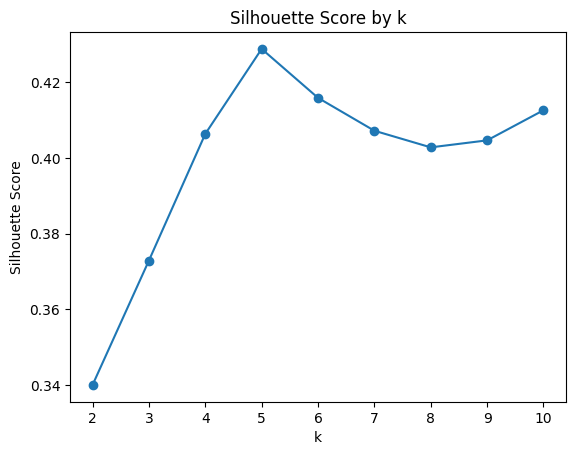

,k,inertia,silhouette
0,2,22862.757983,0.340048
1,3,15434.120524,0.372930
2,4,11460.594403,0.406398
3,5,9222.645069,0.428850
4,6,7344.273937,0.415916
5,7,6305.158576,0.407224
6,8,5643.958685,0.402832
7,9,5013.342216,0.404683
8,10,4440.947970,0.412639


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ks = range(2, 11)
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method (KMeans)")
plt.show()

# Silhouette plot
plt.figure()
plt.plot(list(ks), silhouettes, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by k")
plt.show()

# Table view
pd.DataFrame({"k": list(ks), "inertia": inertias, "silhouette": silhouettes})


In [11]:
best_k = 5

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# df_seg keeps only rows used in clustering (same index as X after dropna)
df_seg = df.loc[X.index].copy()
df_seg["segment"] = labels

df_seg[["segment", "churn_proba", "tenure", "MonthlyCharges", "TotalCharges"]].head()


,segment,churn_proba,tenure,MonthlyCharges,TotalCharges
0,2,0.622651,1,29.85,29.85
1,1,0.044294,34,56.95,1889.50
2,2,0.286630,2,53.85,108.15
3,1,0.028434,45,42.30,1840.75
4,2,0.690068,2,70.70,151.65


In [12]:
# Segment sizes
sizes = df_seg["segment"].value_counts().sort_index()
sizes


segment
0    1764
1    2246
2    1896
3     646
4     480
Name: count, dtype: int64

In [13]:
# Core averages by segment
profile_means = df_seg.groupby("segment")[seg_features].mean().round(2)
profile_means


,tenure,MonthlyCharges,TotalCharges,churn_proba,SeniorCitizen
segment,,,,,
0,58.49,88.53,5178.35,0.12,0.00
1,29.98,31.25,937.83,0.09,0.01
2,10.52,73.03,852.26,0.52,0.00
3,14.90,76.11,1200.48,0.59,1.00
4,58.13,86.77,5049.60,0.20,1.00


In [14]:
# Add churn rate by segment if true label exists (0/1)
if "Churn" in df_seg.columns:
    churn_rate = df_seg.groupby("segment")["Churn"].mean().round(3)
    churn_rate
else:
    print("No 'Churn' column found.")


In [15]:
# Combined profile table (easy to read)
profile = profile_means.copy()
profile["segment_size"] = sizes.values

if "Churn" in df_seg.columns:
    profile["actual_churn_rate"] = df_seg.groupby("segment")["Churn"].mean().values

profile


,tenure,MonthlyCharges,TotalCharges,churn_proba,SeniorCitizen,segment_size,actual_churn_rate
segment,,,,,,,
0,58.49,88.53,5178.35,0.12,0.00,1764,0.125283
1,29.98,31.25,937.83,0.09,0.01,2246,0.087711
2,10.52,73.03,852.26,0.52,0.00,1896,0.514241
3,14.90,76.11,1200.48,0.59,1.00,646,0.586687
4,58.13,86.77,5049.60,0.20,1.00,480,0.202083


In [16]:
# Final segment names (based on Phase 3 profiling)
segment_names = {
    0: "Loyal High-Value (Low Risk)",
    1: "Budget Loyal (Lowest Risk)",
    2: "Early-Life High-Risk (Premium)",
    3: "Senior High-Risk Newcomers",
    4: "Senior Loyal High-Value (Watchlist)"
}

df_seg["segment_name"] = df_seg["segment"].map(segment_names)

# Quick view
df_seg[["segment", "segment_name"]].drop_duplicates().sort_values("segment")


,segment,segment_name
9,0,Loyal High-Value (Low Risk)
1,1,Budget Loyal (Lowest Risk)
0,2,Early-Life High-Risk (Premium)
20,3,Senior High-Risk Newcomers
30,4,Senior Loyal High-Value (Watchlist)


In [17]:
segment_summary = (
    df_seg.groupby(["segment", "segment_name"])
    .agg(
        customers=("segment", "size"),
        avg_tenure=("tenure", "mean"),
        avg_monthly_charges=("MonthlyCharges", "mean"),
        avg_total_charges=("TotalCharges", "mean"),
        avg_churn_proba=("churn_proba", "mean"),
        actual_churn_rate=("Churn", "mean") if "Churn" in df_seg.columns else ("churn_proba", "mean")
    )
    .round(3)
    .reset_index()
    .sort_values("actual_churn_rate", ascending=False)
)

segment_summary


,segment,segment_name,customers,avg_tenure,avg_monthly_charges,avg_total_charges,avg_churn_proba,actual_churn_rate
3,3,Senior High-Risk Newcomers,646,14.901,76.113,1200.479,0.593,0.587
2,2,Early-Life High-Risk (Premium),1896,10.523,73.033,852.256,0.520,0.514
4,4,Senior Loyal High-Value (Watchlist),480,58.127,86.775,5049.601,0.197,0.202
0,0,Loyal High-Value (Low Risk),1764,58.487,88.534,5178.353,0.116,0.125
1,1,Budget Loyal (Lowest Risk),2246,29.982,31.254,937.826,0.094,0.088


In [20]:
df_seg.to_csv("../data/processed/phase3_segmented_customers.csv", index=False)
print("Saved: data/processed/phase3_segmented_customers.csv")



Saved: data/processed/phase3_segmented_customers.csv


## Phase 3 — Key Insights
- Early-life customers show the highest churn risk
- Senior customers require differentiated strategies
- Segment-based retention enables targeted interventions
